<a href="https://colab.research.google.com/github/NicolasCoiado/arvore-remedios/blob/main/arvore_remedios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv("/content/drug200.csv")

Abaixo, temos a primeira etapa do projeto: implementar **codificação categórica**, de modo a melhorar a performance do meu modelo.



In [ ]:
# Implementando codificação categórica.
encoder = LabelEncoder()

df['Sex'] = encoder.fit_transform(df['Sex'])
df['BP'] = encoder.fit_transform(df['BP'])
df['Cholesterol'] = encoder.fit_transform(df['Cholesterol'])
df['Drug'] = encoder.fit_transform(df['Drug'])

O primeiro passo para entender o dataset foi investigar a possibilidade de *correlacionar* a pressão sanguínea e os níveis de colesterol dos pacientes com a **idade** deles. O objetivo dessa análise era verificar se problemas relacionados à pressão sanguínea e ao colesterol aumentam com a idade dos pacientes.

Compreender essa correlação poderia fornecer indícios sobre quais características poderiam ter maior peso no meu modelo, ajudando a identificar se a idade seria um fator determinante para a escolha de uma droga específica.

Para iniciar essa análise, dividi os pacientes em diferentes faixas etárias:

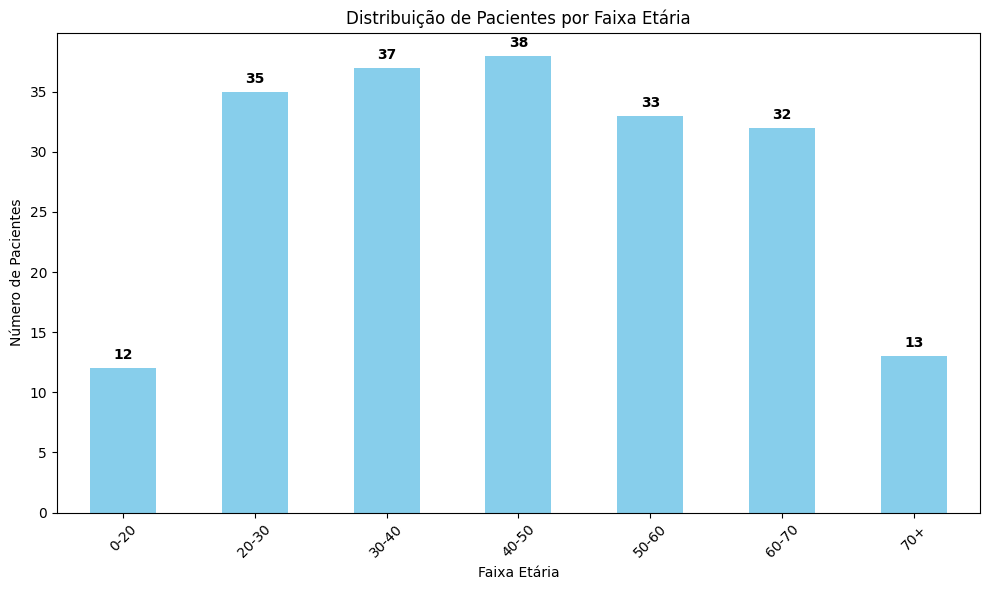

In [ ]:
bins_ages = [0, 20, 30, 40, 50, 60, 70, float('inf')] # Definindo os intervalos de idades para os pacientes.
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+'] # Definindo rótulos do gráfico.
df['Age_Group'] = pd.cut(df['Age'], bins=bins_ages, labels=labels, right=False) # Segmentando os valores de "Age" a partinr dos intervalos.

age_group_counts = df['Age_Group'].value_counts().sort_index()
# Acima estou contando quantas vezes cada faixa etária aparece na coluna Age_Group e ordenando os resultados na mesma ordem dos rótulos definidos em labels.

plt.figure(figsize=(10, 6)) # Criando uma nova figura com dimensões de 10x6.
ax = age_group_counts.plot(kind='bar', color='skyblue') # Plotando um gráfico de barras com os valores de age_group_counts.

# Abaixo faço com que os valores apareçam acima das barras do gráfico.
for i, v in enumerate(age_group_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Abaixo finalizo algumas configurações essenciais para implementação do gráfico.
plt.title('Distribuição de Pacientes por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Pacientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como é possível observar, existem **poucos pacientes** nas faixas etárias de 0 à 20 anos, e mais de 70 anos.


Após compreender a distribuição de pacientes por faixa etária, calculei o coeficiente de correlação entre a pressão sanguínea e a idade, e entre o colesterol e a idade. Optei pelo [método de Spearman](https://estatisticafacil.org/glossario/o-que-e-teste-de-correlacao-de-spearman/), pois os dados não seguem uma distribuição normal ou uma relação linear, apresentando grande variação entre os pacientes.

In [ ]:
correlation_age_bp = df['Age'].corr(df['BP'], method='spearman')

print(f"Coeficiente de Correlação entre Idade e Pressão Sanguínea: {round(correlation_age_bp, 3)}")


Coeficiente de Correlação entre Idade e Pressão Sanguínea: 0.063


In [ ]:
correlation_age_cholesterol= df['Age'].corr(df['Cholesterol'], method='spearman')

print(f"Coeficiente de Correlação entre Idade e Colesterol: {round(correlation_age_cholesterol, 3)}")

Coeficiente de Correlação entre Idade e Colesterol: -0.069


Como é possível observar, existem correlações **muito baixas** ou **quase inexistentes** entre a idade do paciente e os problemas de pressão sanguínea ou colesterol.



Percebi que isso *pode* ocorrer porque todos os pacientes no dataset já fazem uso de algum medicamento. Isso sugere que todos ou a maior parte deles possuem problemas semelhantes relacionados ao colesterol ou à pressão. Acredito que, para estabelecer uma correlação mais robusta entre essas variáveis, seriam necessários dados adicionais, incluindo informações de pacientes que não fazem uso de medicações.

Observação: Conforme [Aryan Gupta](https://www.simplilearn.com/tutorials/statistics-tutorial/spearmans-rank-correlation), devemos interpretar um coeficiente de correlação da seguinte forma:
> Um valor de +1 significa uma associação perfeita de classificação.

> Um valor de 0 significa que não há associação entre as classificações.

> Um valor de -1 significa uma associação negativa perfeita de classificação.

Após observar que não seria possível estabelecer correlações entre a pressão sanguínea/colesterol e a idade do paciente, passei a investigar possíveis tendências entre a pressão sanguínea, os níveis de colesterol e o **gênero** dos pacientes.

Com essa análise, meu objetivo era compreender como o gênero poderia influenciar a interpretação do meu modelo em relação a problemas de colesterol e pressão sanguínea.

O primeiro passo da análise foi entender a distribuição de gênero no meu dataset, verificando **quantos** pacientes *homens* e **quantas** pacientes *mulheres* estavam presentes.

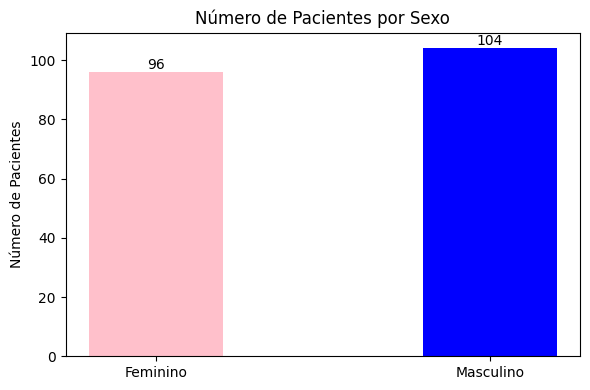

In [ ]:
sex_counts = df['Sex'].value_counts() # Contando a quantidade de pacientes masculinos e femininos.

# Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(sex_counts.index, sex_counts.values, color=['blue', 'pink'], width=0.4)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Feminino', 'Masculino'])
ax.set_title('Número de Pacientes por Sexo')
ax.set_ylabel('Número de Pacientes')

# Abaixo, adiciono os valores acima das barras.
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(int(height)),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Como podemos observar, há uma leve diferença na quantidade de homens e mulheres no dataset, com **8 homens a mais**. Essa discrepância, como veremos a seguir, **teve impacto** nos resultados das tendências analisadas.

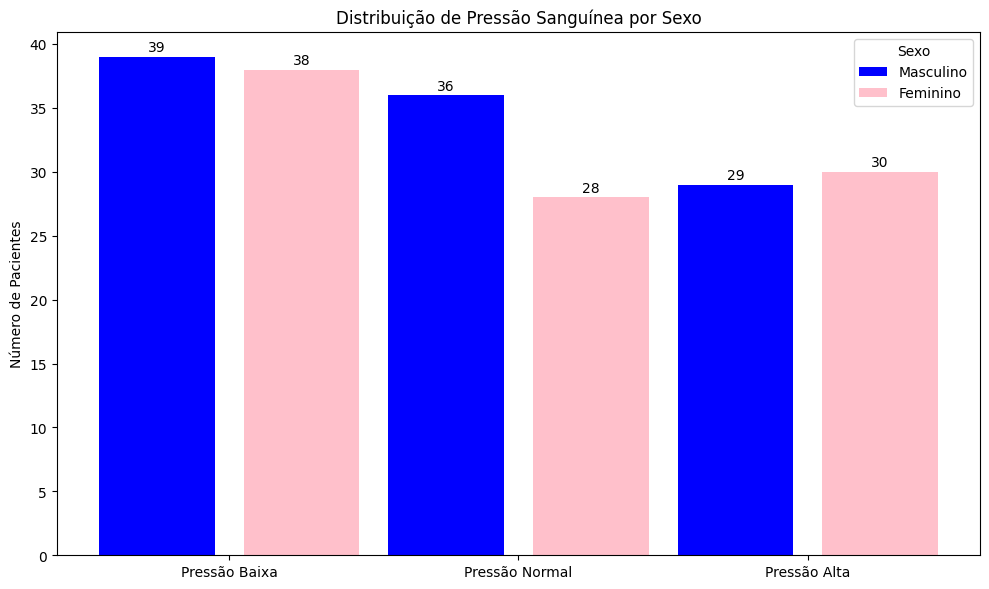

In [ ]:
sex_bp_counts = df.groupby(['Sex', 'BP']).size().unstack(fill_value=0)
# Realizando o agrupamento do dataframe com base nas colunas "Sex" e "BP", a contagem de ocorrências nos resultados, e a reformatação dos dados.

# Abaixo, exibo o gráfico dos dados agrupados acima.
fig, ax = plt.subplots(figsize=(10, 6))

bars = []
bars.append(ax.bar(0, sex_bp_counts.loc[1, 0], color='blue'))
bars.append(ax.bar(1, sex_bp_counts.loc[0, 0], color='pink'))

bars.append(ax.bar(2, sex_bp_counts.loc[1, 1], color='blue'))
bars.append(ax.bar(3, sex_bp_counts.loc[0, 1], color='pink'))

bars.append(ax.bar(4, sex_bp_counts.loc[1, 2], color='blue'))
bars.append(ax.bar(5, sex_bp_counts.loc[0, 2], color='pink'))

ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Pressão Baixa', 'Pressão Normal', 'Pressão Alta'])

for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=10)

ax.set_title('Distribuição de Pressão Sanguínea por Sexo')
ax.set_ylabel('Número de Pacientes')

ax.legend(['Masculino', 'Feminino'], title="Sexo", loc="upper right")

plt.tight_layout()
plt.show()

Como já era esperado, a maior quantidade de homens no dataset impactou os dados, entretanto quando se trata de **pressão alta**, as **mulheres superaram os homens**.

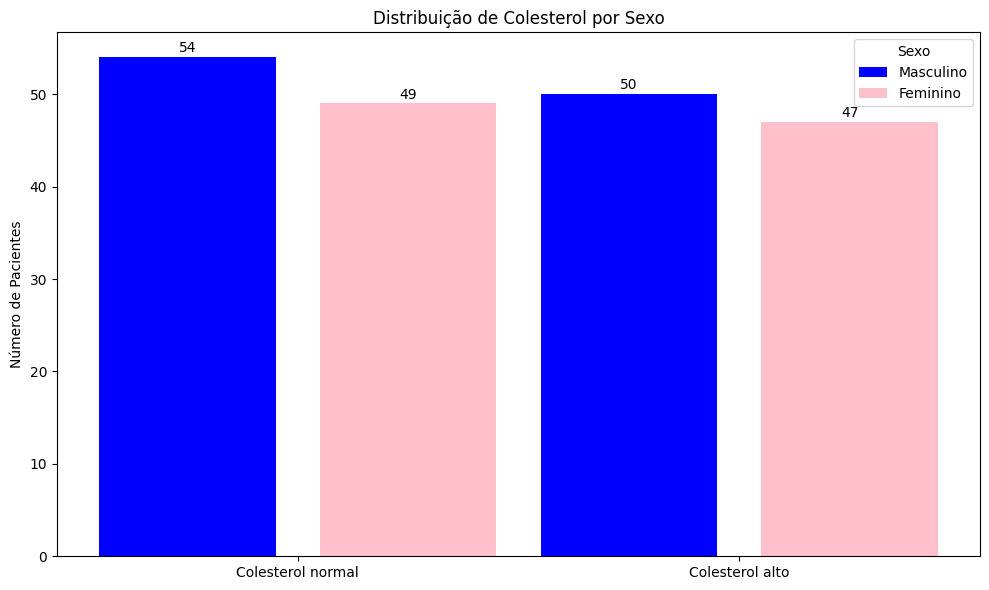

In [ ]:
sex_cholesterol_counts = df.groupby(['Sex', 'Cholesterol']).size().unstack(fill_value=0)
# Realizando o agrupamento do dataframe com base nas colunas "Sex" e "Cholesterol", a contagem de ocorrências nos resultados, e a reformatação dos dados.

# Abaixo, exibo o gráfico dos dados agrupados acima.
fig, ax = plt.subplots(figsize=(10, 6))

bars = []
bars.append(ax.bar(0, sex_cholesterol_counts.loc[1, 0], color='blue'))
bars.append(ax.bar(1, sex_cholesterol_counts.loc[0, 0], color='pink'))

bars.append(ax.bar(2, sex_cholesterol_counts.loc[1, 1], color='blue'))
bars.append(ax.bar(3, sex_cholesterol_counts.loc[0, 1], color='pink'))

ax.set_xticks([0.5, 2.5])
ax.set_xticklabels(['Colesterol normal', 'Colesterol alto'])

for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=10)

ax.set_title('Distribuição de Colesterol por Sexo')
ax.set_ylabel('Número de Pacientes')
ax.legend(['Masculino', 'Feminino'], title="Sexo", loc="upper right")
plt.tight_layout()
plt.show()

Mais uma vez, observamos que a diferença entre os gêneros no dataset influencia os gráficos. Isso sugere que, caso não houvesse essa discrepância, poderia haver um equilíbrio entre os níveis de colesterol nos pacientes.

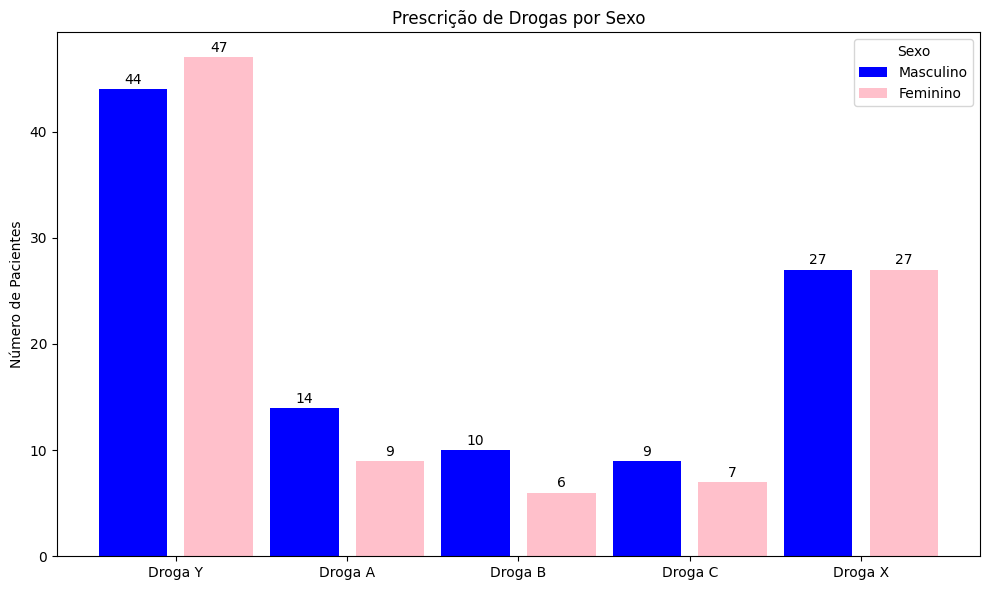

In [ ]:
drug_by_sex = df.groupby(['Sex', 'Drug']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

bars = []
bars.append(ax.bar(0, drug_by_sex.loc[1, 0], color='blue'))
bars.append(ax.bar(1, drug_by_sex.loc[0, 0], color='pink'))

bars.append(ax.bar(2, drug_by_sex.loc[1, 1], color='blue'))
bars.append(ax.bar(3, drug_by_sex.loc[0, 1], color='pink'))

bars.append(ax.bar(4, drug_by_sex.loc[1, 2], color='blue'))
bars.append(ax.bar(5, drug_by_sex.loc[0, 2], color='pink'))

bars.append(ax.bar(6, drug_by_sex.loc[1, 3], color='blue'))
bars.append(ax.bar(7, drug_by_sex.loc[0, 3], color='pink'))

bars.append(ax.bar(8, drug_by_sex.loc[1, 4], color='blue'))
bars.append(ax.bar(9, drug_by_sex.loc[0, 4], color='pink'))

ax.set_xticks([0.5, 2.5, 4.5, 6.5, 8.5])
ax.set_xticklabels(['Droga Y', 'Droga A', 'Droga B', 'Droga C', 'Droga X'])

for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=10)

ax.set_title('Prescrição de Drogas por Sexo')
ax.set_ylabel('Número de Pacientes')
ax.legend(['Masculino', 'Feminino'], title="Sexo", loc="upper right")
plt.tight_layout()
plt.show()

Falando sobre a prescrição de medicamentos por gênero, podemos observar que as mulheres apresentam uma leve tendência a receberem prescrição da **Droga Y**

Após a análise das tendências por gênero, passei a investigar as correlações entre as variáveis "Pressão Sanguínea", "Colesterol" e "Proporção de Sódio para Potássio no Sangue" com a droga prescrita aos pacientes.

In [ ]:
correlation_NA_to_K_Drug = df['Na_to_K'].corr(df['Drug'], method='spearman')

print(f"Coeficiente de Correlação entre proporção de sódio para potássio no sangue (NA_to_K) e o remédio prescrito: {round(correlation_NA_to_K_Drug, 3)}")

Coeficiente de Correlação entre proporção de sódio para potássio no sangue (NA_to_K) e o remédio prescrito: -0.807


In [ ]:
correlation_Cholesterol_Drug = df['Cholesterol'].corr(df['Drug'], method='spearman')

print(f"Coeficiente de Correlação entre colesterol e o remédio prescrito: {round(correlation_Cholesterol_Drug, 3)}")

Coeficiente de Correlação entre colesterol e o remédio prescrito: 0.053


In [ ]:
correlation_BP_Drug = df['BP'].corr(df['Drug'], method='spearman')

print(f"Coeficiente de Correlação entre pressão sanguínea e o remédio prescrito: {round(correlation_BP_Drug, 3)}")

Coeficiente de Correlação entre pressão sanguínea e o remédio prescrito: 0.342


Como observado acima, a **pressão sanguínea** apresentou uma **leve correlação** positiva com o medicamento prescrito. Surpreendentemente, a **proporção de sódio para potássio no sangue** mostrou uma **forte correlação negativa** com o medicamento prescrito.

In [ ]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']] # Atributos de um paciente
y = df['Drug'] # Variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Separando os dados

model = DecisionTreeClassifier() # Instanciando a árvore de decisão
model = model.fit(X_train,y_train) # Realizando o treinamento do modelo

In [ ]:
y_pred = model.predict(X_test) # Realizando uma predição com o modelo.

Abaixo, realizo um **levantamento da importância de cada variável** no aprendizado do modelo. O objetivo era verificar se o modelo refletiria os padrões identificados na análise de tendências e correlações realizadas anteriormente.

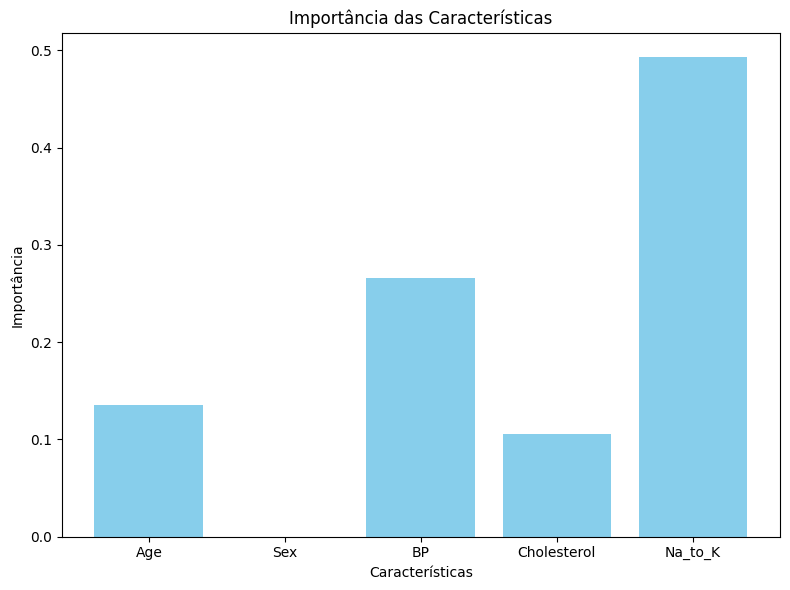

In [ ]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 6))
plt.bar(features, importances, color='skyblue')
plt.title('Importância das Características')
plt.xlabel('Características')
plt.ylabel('Importância')
plt.tight_layout()
plt.show()

Conforme identificado na análise, as variáveis **'Na_to_K' e 'BP' foram as que exerceram maior influência** no aprendizado do modelo, enquanto a variável '**Sex' não apresentou relevância**. Surpreendentemente, as variáveis 'Age' e 'Cholesterol' demonstraram alguma influência no modelo, um resultado que diverge das tendências observadas nas análises anteriores.

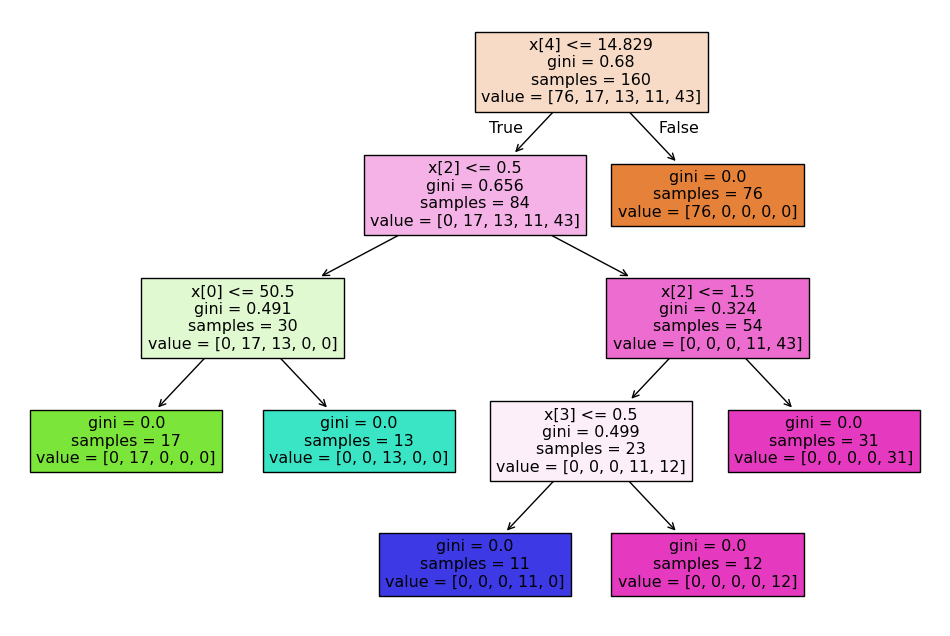

In [ ]:
plt.figure(figsize=(12,8))
tree.plot_tree(model, filled=True)
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 1.0


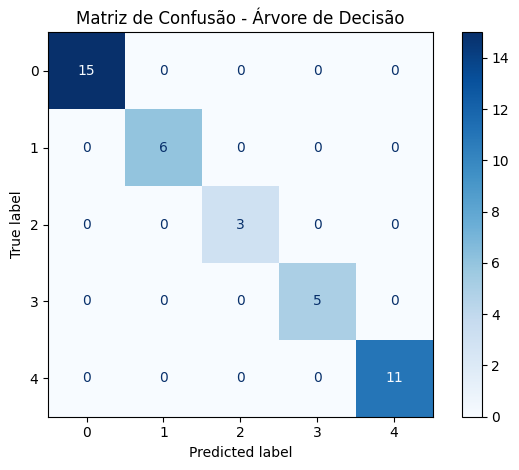

In [ ]:
# Gerar a matriz de confusão
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão com rótulos
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

plt.title("Matriz de Confusão - Árvore de Decisão")
plt.tight_layout()
plt.show()

In [ ]:
novos_pacientes = pd.DataFrame({
    'Age': [25, 55, 40],
    'Sex': [0, 1, 0],
    'BP': [1, 2, 1],
    'Cholesterol': [1, 0, 1],
    'Na_to_K': [15.5, 10.2, 18.7]
})

previsoes = model.predict(novos_pacientes)

drogas = {
    0: "Droga Y",
    1: "Droga A",
    2: "Droga B",
    3: "Droga C",
    4: "Droga X"
}

previsoes = model.predict(novos_pacientes)

for i, previsao in enumerate(previsoes, start=1):
    droga_nome = drogas[previsao]
    print(f"Paciente {i}, Droga recomendada: {droga_nome}")

Paciente 1, Droga recomendada: Droga Y
Paciente 2, Droga recomendada: Droga X
Paciente 3, Droga recomendada: Droga Y
